# Améliorer knn en utilisant l'algorithme d'arbre

Dans ce projet, nous nous intéressons aux différents moyens de recherche des k voisins plus proches d'un point X dans un jeu de données. 

In [1]:
from sklearn import datasets
from pprint import pprint
import pandas as pd
import timeit
from math import sqrt
import heapq
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition

## Datasets

Nous allons exécuter nos programmes sur plusieurs jeu de données : Boston, Diabetes, Olivetti Faces. 

### Iris Dataset (Toy Dataset)

Ce jeu de données contient 4 colonnes donnant la largeur et longueur des pétales et sépales de différentes iris. 
Nous allons travailler sur deux colonnes : 
- **Petal length** : Longueur de la pétale 
- **Petal width** : Largeur de la pétale 

In [2]:
iris = datasets.load_iris()
iris_corr = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_corr.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


In [3]:
iris_data = iris.data[:, [2, 3]].tolist()
iris_data_len = len(iris_data)
df_iris = pd.DataFrame(iris_data)
df_iris.describe()

,0,1
count,150.000000,150.000000
mean,3.758000,1.199333
std,1.765298,0.762238
min,1.000000,0.100000
25%,1.600000,0.300000
50%,4.350000,1.300000
75%,5.100000,1.800000
max,6.900000,2.500000


### Wine Dataset (Toy Dataset)

Ce jeu de données contient 13 colonnes pour les 13 analyses différentes faite sur différents vins provenant d'un même secteur en Italie. 

Nous allons travailler sur deux colonnes : 
- **Flavonoïde** : Pigmentation responsable de la coloration du vin 
- **Total_phenols** : Groupe de composés chimiques qui affectent la couleur

In [4]:
wine = datasets.load_wine()
wine_corr = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_corr.corr()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


In [5]:
wine_data = wine.data[:, [6, 10]].tolist()
wine_data_len = len(wine_data)
df_diabetes = pd.DataFrame(wine_data)
df_diabetes.describe()

,0,1
count,178.000000,178.000000
mean,2.029270,0.957449
std,0.998859,0.228572
min,0.340000,0.480000
25%,1.205000,0.782500
50%,2.135000,0.965000
75%,2.875000,1.120000
max,5.080000,1.710000


### Forest Covertypes Dataset (Real World Dataset)

Ce dernier jeu de données concerne les couvertures forestières, c’est-à-dire les superficies des terres couvertes par la forêt, aux Etats-Unis. Il contient 13 variables dont 3 qui sont développées en plusieurs colonnes c’est pour cela qu’il y a plus de 13 colonnes. 

Nous allons travailler sur deux colonnes : 
- **Horizontal_Distance_To_Hydrology**: La distance en horizontal entre la plateforme où y a les arbres et la plateforme où y a de l'eau
- **Vertical_Distance_To_Hydrology**: La distance en vertical entre la plateforme où y a les arbres et la plateforme où y a de l'eau

In [6]:
forest_covertypes = datasets.fetch_covtype()
forest_covertypes_corr = pd.DataFrame(forest_covertypes.data)
forest_covertypes_corr.corr()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022,...,0.070405,0.167077,0.070633,0.011731,0.083005,0.021107,0.035433,0.217179,0.193595,0.212612
1,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172,...,0.001763,0.056233,0.019163,0.010861,-0.021991,0.002281,-0.020398,0.017706,0.008294,-0.005866
2,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662,...,-0.034610,-0.133504,0.208942,-0.011002,-0.022228,0.002918,0.007848,-0.072208,0.093602,0.025637
3,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874,...,0.073658,0.127217,0.101195,0.070268,-0.005231,0.033421,-0.006802,0.043031,0.031922,0.147020
4,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913,...,0.033609,0.039762,0.167091,0.060274,-0.006092,0.012955,-0.007520,-0.008629,0.043859,0.179006
5,0.365559,0.025121,-0.215914,0.072030,-0.046372,1.000000,0.034349,0.189461,0.106119,0.331580,...,-0.058840,-0.089019,-0.082779,0.006390,-0.003000,0.007550,0.016313,0.079778,0.033762,0.016052
6,0.112179,-0.579273,-0.327199,-0.027088,-0.166333,0.034349,1.000000,0.010037,-0.780296,0.132669,...,-0.035114,0.006494,-0.064381,0.007154,0.027870,0.007865,0.010332,0.015108,-0.029620,-0.000016
7,0.205887,0.336103,-0.526911,0.046790,-0.110957,0.189461,0.010037,1.000000,0.594274,0.057329,...,-0.000095,0.125395,-0.086164,0.043061,0.005863,0.016239,-0.022707,0.042952,-0.071961,-0.040176
8,0.059148,0.646944,-0.175854,0.052330,0.034902,0.106119,-0.780296,0.594274,1.000000,-0.047981,...,0.040475,0.083066,-0.024393,0.017757,-0.016482,0.001330,-0.022064,0.022187,-0.029040,-0.024254
9,0.148022,-0.109172,-0.185662,0.051874,-0.069913,0.331580,0.132669,0.057329,-0.047981,1.000000,...,-0.066258,-0.089977,-0.059067,-0.035067,-0.000081,-0.010595,0.004180,-0.019740,-0.003301,0.008915


In [7]:
forest_covertypes_data = forest_covertypes.data[:, [3,4]]
forest_covertypes_data = forest_covertypes_data.tolist()
forest_covertypes_data = forest_covertypes_data[:1000]
forest_covertypes_data_len = len(forest_covertypes_data)
df_forest_covertypes = pd.DataFrame(forest_covertypes_data)
df_forest_covertypes.describe()

,0,1
count,1000.000000,1000.000000
mean,236.588000,30.960000
std,189.964572,37.223917
min,0.000000,-45.000000
25%,85.000000,4.000000
50%,201.000000,20.000000
75%,342.000000,46.000000
max,997.000000,245.000000


## K Nearest Neighbors

Ici, nous allons comparer deux manières de trouver les k voisins les plus proches : 
- Avec un arbre des médianes 
- D'une manière naïve

### Knn Kd-tree

En premier lieu, nous avons créé une fonction permettant d'obtenir un arbre afin d'optimiser les recherches. 
Pour cela nous calculons la médiane de notre jeu de données, préalablement trié, et séparons celui-ci en deux afin de créer deux feuilles: droite (points suppérieurs à la médiane) et gauche (points inférieurs à la médiane ainsi que la médiane). Nous exécutons ce processus sur chacunes des feuilles qui créées des jeux de données de plus en plus petit. Cet algorithme s'arrête une fois que le jeu de données ne contient qu'un point. 
Nous créons ainsi une liste contenant tous ces points que nous appelons kd_tree: elle contient chaque feuille de l'arbre.


In [8]:
def gen_kd_tree(data: list, col_index=0):
    next_col_index = 1 if col_index == 0 else 0
    if len(data) > 1:
        data.sort(key=lambda z: z[col_index])
        median_index = len(data) >> 1

        median_point = data[median_index]
        
        #split array at median point
        leaf_right = data[median_index + 1:]
        leaf_left = data[:median_index]
        
        return [
            median_point,
            gen_kd_tree(leaf_left, next_col_index),
            gen_kd_tree(leaf_right, next_col_index),
        ]
    elif len(data) == 1:
        return [data[0], None, None]

Dans un deuxième temps, nous cherchons les k voisins plus proches d'un point X et nous les mettons dans une nouvelle liste : nearest_neighbors. 
Pour construire nearest_neighbors, cette liste se remplit directement par les premiers points de la liste kd_tree, sans prendre en compte les calculs des distances que nous allons expliquer ensuite. Cependant notre liste des voisins est directement trié pour qu'on obtienne, dans l'ordre, la distance entre chaque point de kd_tree et X. De plus, cela s'arrêtera lorsque la liste (nearest_neighbors) aura atteint le nombre de voisins (k) souhaités. 

Pour chaque point, nous allons effectuer plusieurs calculs et manipulations : 
- En récupérant la liste des feuilles de l'arbre créé, nous calculons la distance euclidienne entre le point X et un point enregistré dans kd_tree. Ensuite, nous calculons la différence entre les x-coordinate (ou y-coordinate) du point et de X, selon le niveau de l'arbre (feuille impaire : x-coordinate et feuille paire : y-coordinate).

- Cela ne s'exécute uniquement après que nearest_neighbors est atteint la taille souhaitée (taille = k): 
    - Nous comparons les points enregistrés dans la liste des voisins par les résultats obtenus avec notre calcul des distances. Si la distance du nouveau point est plus petite que la distance maximale enregistrée dans nearest_neighbors, on remplace celle-ci par les données du même point (son point et sa distance avec X). 
    - Nous allons ensuite regarder si la distance maximale enregistrée dans nearest_neighbors est plus petite que la différence entre x/y-coordinate. Si c'est le cas, nous travaillons ensuite que sur la feuille gauche: donc uniquement la partie avant le point sur lequel on travaille. Si ce n'est pas le cas, nous travaillons sur les deux feuilles qui suivent car nous ne pouvons pas savoir quel point est le plus proche entre les deux points suivant. Nous faisons cela en suivant les branches de l'arbre.

Nous effectuons ainsi ces calculs avec tous les points de kd_tree. 

Une fois fini, nous changeons l'ordre nearest_neighbors qui, pour faciliter les manipulations, présentaient d'abord les distances avant les points. 
De ce fait, nearest_neighbors contient les k plus proches voisins de X. 

In [9]:
def find_knn(kd_tree, target_point, k, nearest_neighbors=None, z=0):
    next_z = 1 if z == 0 else 0

    # si nearest neighors vide -> source TRUE
    source = not nearest_neighbors

    #si TRUE -> créé une liste vide
    if source:
        nearest_neighbors = []
        
    #si kd_tree n'est pas nul
    if kd_tree:
        #calcul de la distance euclidienne et de la distance entre les x ou les y
        node = kd_tree[0]
        dist_e = distance(node, target_point)
        dist_xy = abs(node[z] - target_point[z])

        if len(nearest_neighbors) < k:
            #si nearest_neighbors toujours pas rempli 
            #-> continuer de rajouter les points dans la liste
            heapq.heappush(nearest_neighbors, (-dist_e, node))
        elif dist_e < -nearest_neighbors[0][0]:
            #si nearest_neighbors rempli 
            #-> comparer distance euclidienne des nouveaux points avec le point dans la liste qui a la plus grande distance euclidienne
            heapq.heappushpop(nearest_neighbors, (-dist_e, node))

        leaf_togo = [1, 2]
        if dist_xy > -nearest_neighbors[0][0]:
            #si distance entre les x ou les y est plus grande que la distance euclidiennede X et node 
            #-> aller uniquement à gauche sinon aller à gauche et droite
            del leaf_togo[1]
        
        #effectuer cette fonction sur les feuilles qui suivent 
        for i in leaf_togo:
            find_knn(kd_tree[i], target_point, k, nearest_neighbors, next_z)
    
    #une fois fini -> remettre dans l'ordre 
    if source:
        nearest_neighbors = [h[1] for h in nearest_neighbors]
        return nearest_neighbors

On constate que ce processus nous évite d'aller chercher la distance de X avec tous les points, il le fait seulement avec les points proches de la médiane récupérée chaque fois. En effet, en calculant la différence entre les points, on peut éviter de calculer des distances de point qui nous semble déjà lointain de X. 
Il n'est donc pas nécessairement plus efficace sur un jeu avec peu de données mais l'est pour un jeu de données à grande taille. En effet, contrairement à la méthode naïve, il a des exécutions en plus (la création de l'arbre), il ne sera donc pas à son avantage si nous avons peu de données. Au contraire, s'il y en a beaucoup, le fait de simplifier les recherches des voisins les plus proches en s'aidant principalement des médianes, nous fait gagner du temps. 
De même, si la taille du voisin recherché n'est pas grande (si il vaut 1), une nouvelle fois la recherche de l'arbre du jeu de données peut faire perdre du temps. 

En conclusion, plus le jeu de données et le nombre de voisins proches recherchés seront grands, plus ce processus sera davantage rapide. 

### Knn Naive

Recherche des k plus proches voisins d'un point x, dans une collection a de n éléments. Avec : 
- a : liste.
- n et k : entiers tels que : 1 <= k < n.
- un point : couple de valeurs flottantes
On considère que chaque élément représente un point d'un espace euclidien à deux dimensions.

Proches_voisins contient les k plus proches voisins de x. 

In [10]:
def cherche_k_voisins(k, x, a, n):
    proches_voisins = []

    for i in range(k):
        proches_voisins.append(a[i])

    for i in range(k, n):
        for j in range(k):
            #si la distance entre A[i] et x est inférieure 
            #à la distance d'un des points de proches_voisins à x
            if distance(a[i], x) < distance(proches_voisins[j], x):
                #On cherche le point le plus éloigné
                distance_max = distance(proches_voisins[0], x)
                indice_max = 0
                for l in range(k):
                    if distance_max < distance(proches_voisins[l], x):
                        distance_max = distance(proches_voisins[l], x)
                        indice_max = l
                del proches_voisins[indice_max] #le supprime
                proches_voisins.append(a[i]) #ajoute a[i] 
                break #on sort de notre boucle for sinon le calcul va
                #se répéter et a[i] pourrait être rajouté plusieurs fois
            
    return proches_voisins


Distance euclidienne entre deux points (espace à deux dimensions) : 

In [11]:
def distance(a, b):
    distance_euclidean = sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    return distance_euclidean

## Performance

Nous allons maintenant appliquer nos deux processus sur nos différents jeux de données afin de comparer la vitesse d'exécution de nos programmes. 

In [12]:
x = [2, 3]
k_list = [1, 10, 50, 100]
all_datasets = {
                "Iris dataset": iris_data,
                "Wine dataset": wine_data,
                "Forest covertypes": forest_covertypes_data}


Voici le programme pour afficher le graphique des voisins les plus proches : 

In [13]:
def affiche(x, a, n, k_voisins, nb_neighbors):
# Création des deux tableaux (axe x et y) pour affichage des points de a (tableaux numpy)
    tabx_a = np.array([a[i][0] for i in range(n)])
    taby_a = np.array([a[i][1] for i in range(n)])

# Création des deux tableaux (axe x et y) pour affichage des points de k_voisins (tableaux numpy)
    tabx_kv = np.array([k_voisins[i][0] for i in range(len(k_voisins))])
    taby_kv = np.array([k_voisins[i][1] for i in range(len(k_voisins))])
        
# Initialisation des propriétés de l'affichage
    plt.scatter(tabx_a, taby_a, color='gray', label='jeu de données')  # jeu de données
    plt.scatter(tabx_kv, taby_kv, color='b', label='k_voisins et x')  # k_voisins
    plt.scatter(x[0], x[1], color='b', marker='x')  # x
    plt.legend()
    plt.title('k plus proches voisins')
    
# Affichage
    plt.show()

### KNN avec différents k, jeux de données, algorithmes



Iris dataset-taille: 150
knn kdtree avec k = 1: --- 0.001210899999996684 seconds ---


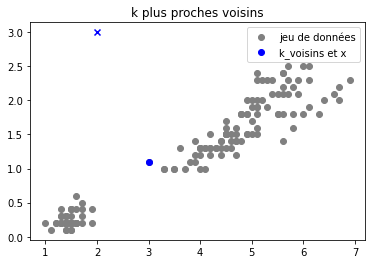

knn naive avec k = 1: --- 0.0008090000000038344 seconds ---


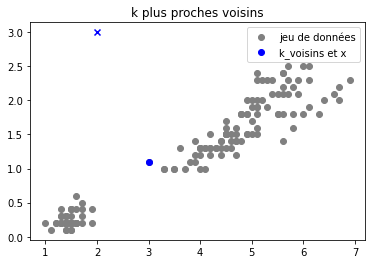

knn kdtree avec k = 10: --- 0.001724100000004114 seconds ---


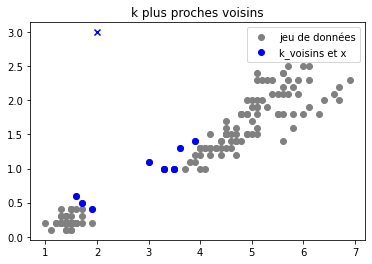

knn naive avec k = 10: --- 0.005697999999995318 seconds ---


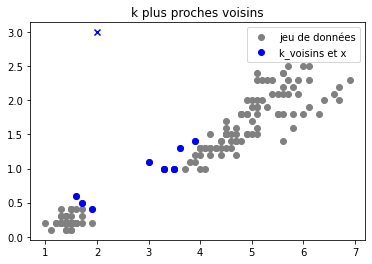

knn kdtree avec k = 50: --- 0.001531700000001024 seconds ---


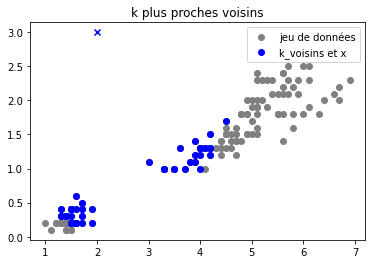

knn naive avec k = 50: --- 0.02093190000000078 seconds ---


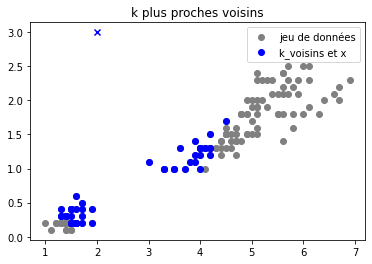

knn kdtree avec k = 100: --- 0.00487179999999654 seconds ---


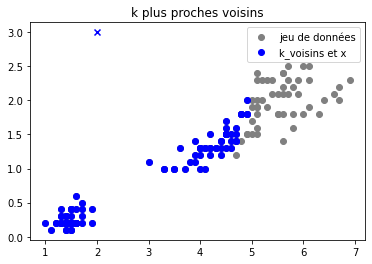

knn naive avec k = 100: --- 0.02441840000000184 seconds ---


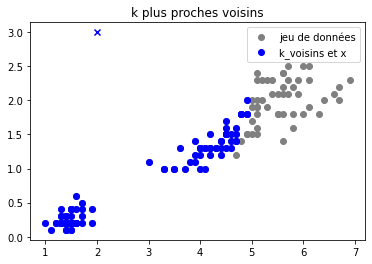

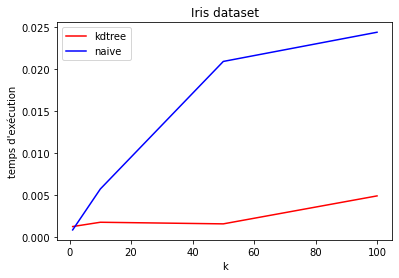



Wine dataset-taille: 178
knn kdtree avec k = 1: --- 0.0013964999999984684 seconds ---


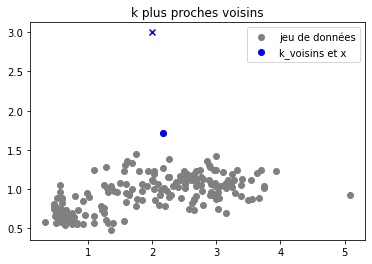

knn naive avec k = 1: --- 0.0009788999999997827 seconds ---


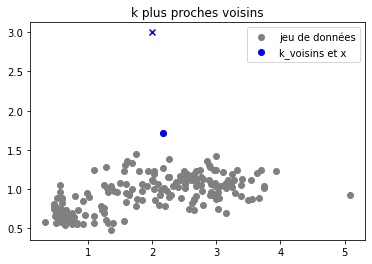

knn kdtree avec k = 10: --- 0.0018655000000009636 seconds ---


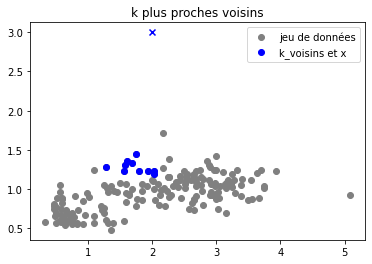

knn naive avec k = 10: --- 0.006730500000003303 seconds ---


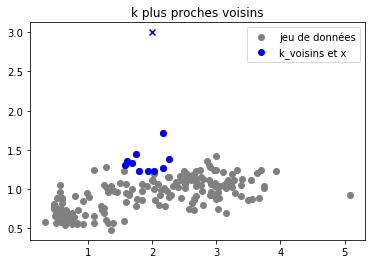

knn kdtree avec k = 50: --- 0.002105499999998983 seconds ---


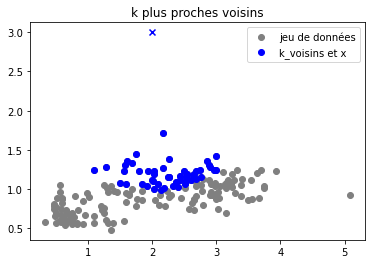

knn naive avec k = 50: --- 0.021454500000004373 seconds ---


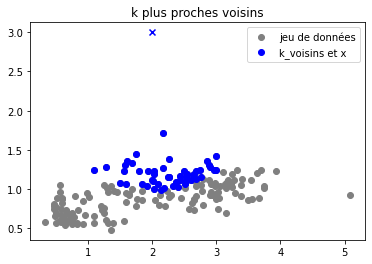

knn kdtree avec k = 100: --- 0.0021375999999975193 seconds ---


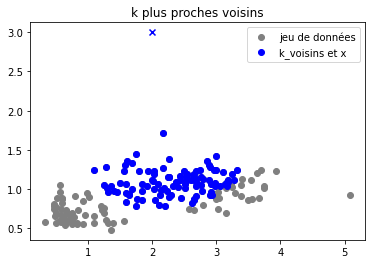

knn naive avec k = 100: --- 0.021560600000000818 seconds ---


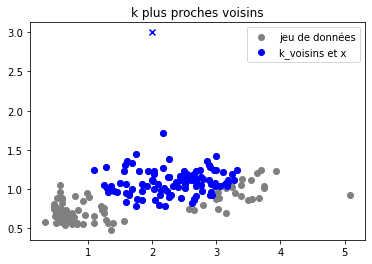

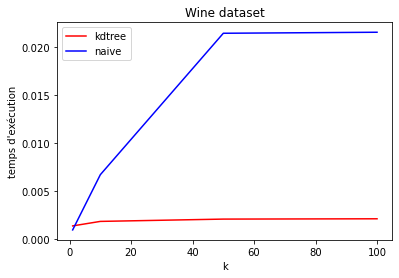



Forest covertypes-taille: 1000
knn kdtree avec k = 1: --- 0.0069676999999970235 seconds ---


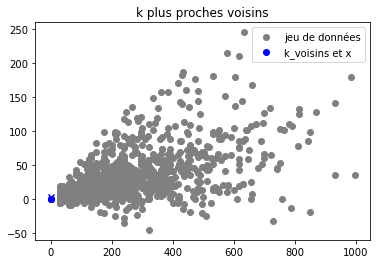

knn naive avec k = 1: --- 0.005521099999995727 seconds ---


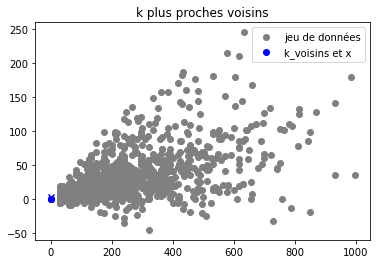

knn kdtree avec k = 10: --- 0.012330200000000957 seconds ---


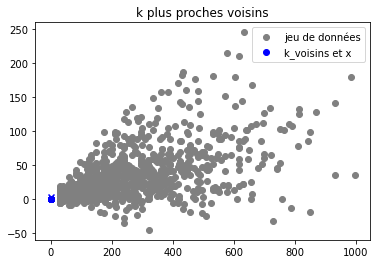

knn naive avec k = 10: --- 0.0530374000000009 seconds ---


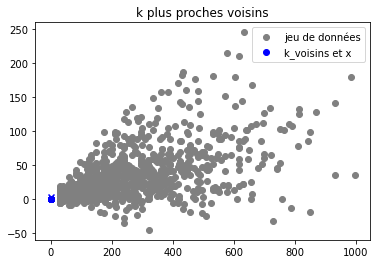

knn kdtree avec k = 50: --- 0.006582199999996874 seconds ---


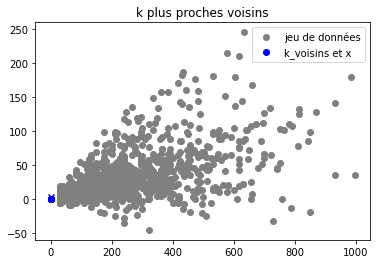

knn naive avec k = 50: --- 0.20978410000000025 seconds ---


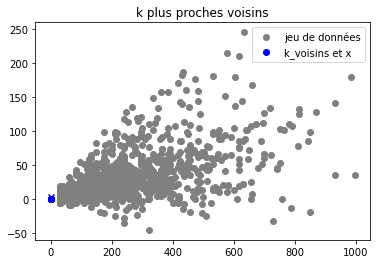

knn kdtree avec k = 100: --- 0.006956899999998711 seconds ---


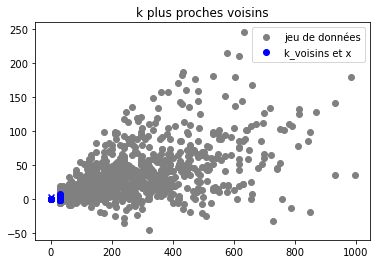

knn naive avec k = 100: --- 0.36711669999999685 seconds ---


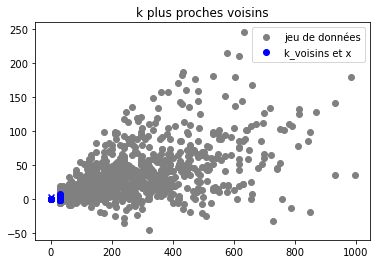

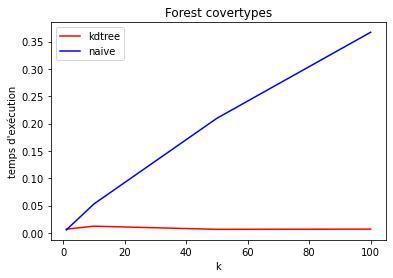

In [14]:
for dataset_name, data in all_datasets.items():
    print("\n")
    print(dataset_name + "-taille: " + str(len(data)))
    kdtree_results = []
    naive_results = []
    for k in k_list:
        
        #kd tree algorithme
        start_time_kdtree = timeit.default_timer()
        kdtree = gen_kd_tree(data)
        kdtree_knn = find_knn(kdtree, x, k)
        time_execution_kdtree = (timeit.default_timer() - start_time_kdtree)
        print("knn kdtree avec k = "+str(k)+": --- %s seconds ---" % (time_execution_kdtree))
        
        affiche(x, data, len(data), kdtree_knn, k)
        kdtree_results.append([k, time_execution_kdtree])
        
        #naive
        start_time_naive = timeit.default_timer()
        knn = cherche_k_voisins(k, x, data, len(data))
        time_execution_naive = (timeit.default_timer() - start_time_naive)
        print("knn naive avec k = "+str(k)+": --- %s seconds ---" % (time_execution_naive))
        
        affiche(x, data, len(data), knn, k)
        naive_results.append([k, time_execution_naive])
        
        
    plt.plot([x[0] for x in kdtree_results], [x[1] for x in kdtree_results], color='red', label='kdtree') 
    plt.plot([x[0] for x in naive_results], [x[1] for x in naive_results], color='b', label='naive') 
    plt.legend()
    plt.xlabel('k')
    plt.ylabel("temps d'exécution")
    plt.title(dataset_name)
    plt.show()

    

En conclusion, nous constatons qu'effectivement, plus le k est grand plus l'algorithme de kd_tree est avantageux. 